# Improving GAN Outputs with Class Conditioning
Submitted by: Rishabh Kaushick
<br>
Date: March 2, 2025

# Environment Setup
- Install the necessary libraries (e.g., TensorFlow or PyTorch, NumPy, Matplotlib).
- Verify that the Fashion MNIST dataset can be successfully loaded using your chosen framework.
- Document your environment setup (e.g., software versions, hardware used).

In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import numpy as np
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import pandas as pd
import seaborn as sns

## Harware Requirements
### CUDA: GPU Availability

In [2]:
 
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
 
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")
    print(f"GPU Count: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
        print(f"Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")
 
else:
    print("CUDA is not available. Running on CPU.")

PyTorch version: 2.2.1+cu121
Is CUDA available: False
CUDA is not available. Running on CPU.


## Software Requirements

In [3]:
!pip freeze

absl-py==2.1.0
accelerate==1.4.0
aiohappyeyeballs==2.4.4
aiohttp==3.11.11
aiosignal==1.3.2
annotated-types==0.7.0
anyio==4.8.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
astunparse==1.6.3
async-lru==2.0.4
async-timeout==5.0.1
attrs==24.3.0
babel==2.16.0
backoff==2.2.1
beautifulsoup4==4.12.3
bioc==2.1
bleach==6.2.0
blis==1.2.0
boto3==1.35.96
botocore==1.35.96
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.12.14
cffi==1.17.1
charset-normalizer==3.4.1
click==8.1.8
cloudpathlib==0.20.0
comm==0.2.2
confection==0.1.5
conllu==4.5.3
contourpy==1.3.1
cycler==0.12.1
cymem==2.0.11
debugpy==1.8.11
decorator==5.1.1
defusedxml==0.7.1
Deprecated==1.2.18
docopt==0.6.2
exceptiongroup==1.2.2
executing==2.1.0
fastapi==0.115.6
fastjsonschema==2.21.1
filelock==3.16.1
fire==0.7.0
flair==0.15.1
flatbuffers==25.1.24
fonttools==4.55.3
fqdn==1.5.1
frozenlist==1.5.0
fsspec==2024.12.0
ftfy==6.3.1
gast==0.6.0
gdown==5.2.0
google-auth==2.37.0
google-auth-oauthlib==1.2.1
google

## Setting Some Parameters

In [10]:
# root directory where the dataset will exist
dataroot = "./data/fashion_mnist"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. 
# All images will be resized to this size using transforms.
image_size = 64

# Number of channels in the training images. (For color images this is 3)
# in our case the Fashion MNIST is a set of grayscale images - so we use 1:
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. (Use 0 for CPU mode)
ngpu = 1


## Setting the device

In [11]:
# decide the device to run (gpu or cpu)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Dataset
## Loading the dataset

In [16]:
# transforming the images - for train & test (before downloading):
    # 1. resize
    # 2. crop the image at the center
    # 3. converting the grayscale to rgb
    # 4. transform to a tensor
    # 5. normalize tensor in the range [-1, 1]

transform = transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.CenterCrop(image_size),
                        # transforms.Grayscale(num_output_channels=3),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, ), (0.5, ))
                    ])

In [17]:
# creating a directory to store the dataset
os.makedirs(dataroot, exist_ok=True)

# Downloading the FashionMNIST dataset from torchvision (into the dataroot folder)

train_dataset = torchvision.datasets.FashionMNIST(root=dataroot, 
                                        download=True,
                                        train=True,
                                        transform=transform
                                    )

test_dataset = torchvision.datasets.FashionMNIST(root=dataroot, 
                                        download=True,
                                        train=False,
                                        transform=transform
                                    )

## Initializing the DataLoader

In [18]:
# DataLoader

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=workers
                                            )
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=workers
                                            )

# Exploratory Data Analysis

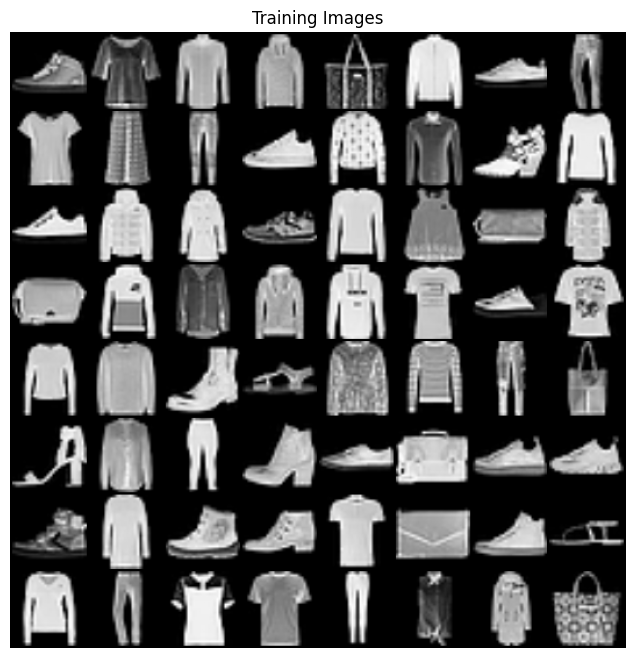

In [21]:
# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Basic DCGAN

## Building DCGAN

## Trainnig DCGAN

## Testing DCGAN

# Conditional GAN (cGAN)

## Trainnig cGAN

## Testing cGAN